In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# @title Imports
# imports
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# @title Data preprocessing
data = np.loadtxt("/content/drive/MyDrive/PRNN/Assignment_1/regression_data_multiGen_group_5_train.txt", skiprows=1, dtype='float')
d=2;
X_original=data[:,0:d]
Y_original=data[:,d:d+3]
# Define proportions for train, validation, and test sets
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 1-train_ratio-val_ratio

# Calculate the sizes of each set
num_samples = len(data)
num_train = int(train_ratio * num_samples)
num_val = int(val_ratio * num_samples)
num_test = num_samples - num_train - num_val

# Split the data into train, validation, and test sets
X_train, y_train = data[:num_train, :-3], data[:num_train, -3:]
X_val, y_val = data[num_train:num_train+num_val, :-3], data[num_train:num_train+num_val, -3:]
X_test, y_test = data[-num_test:, :-3], data[-num_test:, -3:]

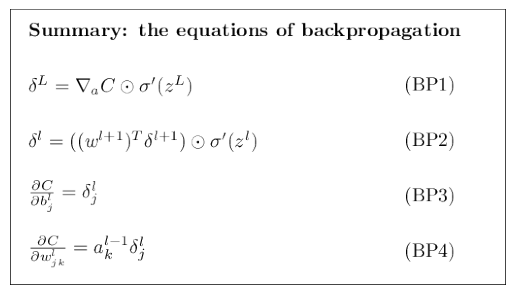

In [5]:
# @title Equations used for back propagation
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load the image
img = mpimg.imread('/content/drive/MyDrive/PRNN/A2/tikz21.png')

# Display the image
plt.imshow(img)
plt.axis('off')  # Turn off axis
plt.show()


In [6]:
# @title MLP class definition for regression
class MLPRegressor(object):
    def __init__(self, lr=1e-2, epochs=100, activation_funcs=['relu', 'relu', 'relu'], layers=[10, 5, 5, 3], l1_reg=0.01,l2_reg=0.01):
        """
        Initialiser function for a class instance

        Inputs:
            lr              -> learning rate
            epochs          -> number of epochs to use during training
            activation_funcs-> list of activation functions for each layer
            layers          -> list containing number of nodes in each layer
            l2_reg          -> L2 regularization parameter
        """
        self.lr = lr
        self.epochs = epochs
        self.activation_funcs = activation_funcs
        self.layers = layers
        self.l2_reg = l2_reg
        self.l1_reg=l1_reg
        self.weights = []
        self.biases = []
        self.train_loss = []
        self.val_loss = []
        self.loss = []

    def _loss(self, y_true, y_pred):
        """
        Function to compute squared-error loss per sample with L2 regularization

        Inputs:
            y_true -> numpy array of true labels
            y_pred -> numpy array of prediction values
        Output:
            loss value
        """
        # Compute mean squared error loss
        mse_loss = 0.5 * np.square(y_true - y_pred)
        # Compute L1 regularization term
        l1_reg_term = self.l1_reg * sum(np.sum(np.abs(w)) for w in self.weights)
        # Compute L2 regularization term
        l2_reg_term = 0.5 * self.l2_reg * sum(np.sum(np.square(w)) for w in self.weights)
        # Add regularization terms to the loss
        total_loss = np.mean(mse_loss) + l1_reg_term + l2_reg_term
        return total_loss

    def __del__(self):
        """
        Destructor function for a class instance
        """
        del self.lr
        del self.epochs
        del self.layers
        del self.biases
        del self.train_loss
        del self.val_loss
        del self.loss


    def _derivative_loss(self, y_true, y_pred):
        """
        Function to compute the derivative of the squared-error loss per sample

        Inputs:
            y_true -> numpy array of true labels
            y_pred -> numpy array of prediction values
        Output:
            loss value
        """
        return -(y_true - y_pred)

    def _sigmoid(self, z):
        """
        Function to compute sigmoid activation function

        Input:
            z -> input dot product w*x + b
        Output:
            determined activation
        """
        return 1 / (1 + np.exp(-z))

    def _derivative_sigmoid(self, z):
        """
        Function to compute the derivative of the sigmoid activation function

        Input:
            z -> input dot product w*x + b
        Output:
            determined derivative of activation
        """
        return self._sigmoid(z) * (1 - self._sigmoid(z))

    def _linear(self, z):
        """
        Function to compute linear activation function

        Input:
            z -> input dot product w*x + b
        Output:
            determined activation
        """
        return z

    def _derivative_linear(self, z):
        """
        Function to compute the derivative of the linear activation function

        Input:
            z -> input dot product w*x + b
        Output:
            determined derivative of activation
        """
        return np.ones(z.shape)

    def _relu(self, z):
        """
        Function to compute ReLU activation function

        Input:
            z -> input dot product w*x + b
        Output:
            determined activation
        """
        return np.maximum(0, z)

    def _derivative_relu(self, z):
        """
        Function to compute the derivative of the ReLU activation function

        Input:
            z -> input dot product w*x + b
        Output:
            determined derivative of activation
        """
        return np.where(z > 0, 1, 0)

    def _tanh(self, z):
        """
        Function to compute Hyperbolic Tangent (tanh) activation function

        Input:
            z -> input dot product w*x + b
        Output:
            determined activation
        """
        return np.tanh(z)

    def _derivative_tanh(self, z):
        """
        Function to compute the derivative of the Hyperbolic Tangent (tanh) activation function

        Input:
            z -> input dot product w*x + b
        Output:
            determined derivative of activation
        """
        return 1 - np.tanh(z) ** 2

    def _activate(self, z, activation_func):
        """
        Function to apply activation function based on given activation_func parameter

        Inputs:
            z -> input dot product w*x + b
            activation_func -> string representing the activation function ('sigmoid', 'linear', 'relu', 'tanh')
        Output:
            determined activation
        """
        if activation_func == 'sigmoid':
            return self._sigmoid(z)
        elif activation_func == 'linear':
            return self._linear(z)
        elif activation_func == 'relu':
            return self._relu(z)


        elif activation_func == 'tanh':
                return self._tanh(z)
        else:
            # Default to linear activation
            return self._linear(z)

    def _derivative_activate(self, z, activation_func):
        """
        Function to compute the derivative of the activation function

        Inputs:
            z -> input dot product w*x + b
            activation_func -> string representing the activation function ('sigmoid', 'linear', 'relu', 'tanh')
        Output:
            determined derivative of activation
        """
        if activation_func == 'sigmoid':
            return self._derivative_sigmoid(z)
        elif activation_func == 'linear':
            return self._derivative_linear(z)
        elif activation_func == 'relu':
            return self._derivative_relu(z)
        elif activation_func == 'tanh':
            return self._derivative_tanh(z)
        else:
            # Default to derivative of linear activation
            return self._derivative_linear(z)

    def _forward_pass(self, X):
        """
        Function to perform forward pass through the network

        Input:
            X -> numpy array of input predictive features with assumed shape [number_features, number_samples]
        Output:
            list of activations & derivatives for each layer
        """
        # record from input layer
        input_to_layer = np.copy(X)
        activations = [input_to_layer]
        derivatives = [np.zeros(X.shape)]

        for i in range(len(self.layers) - 2):
            # Compute the input to the current hidden layer
            z_i = np.matmul(self.weights[i], input_to_layer) + self.biases[i]
            # Apply activation function to the input
            input_to_layer = self._activate(z_i, self.activation_funcs[i])
            # Store activation and derivative
            activations.append(input_to_layer)
            derivatives.append(self._derivative_activate(z_i, self.activation_funcs[i]))

        # Compute the input to the output layer
        z_i = np.matmul(self.weights[-1], input_to_layer) + self.biases[-1]
        # Apply linear activation function for the output layer
        input_to_layer = self._activate(z_i, self.activation_funcs[-1])
        # Store activation and derivative for the output layer
        activations.append(input_to_layer)
        derivatives.append(self._derivative_activate(z_i, self.activation_funcs[-1]))
        # return results
        return activations, derivatives

    def _backward_pass(self, activations, derivatives, y):
        """
        Function to perform backward pass through the network

        Inputs:
            activations -> list of activations from each layer in the network
            derivatives -> list of derivatives from each layer in the network
            y           -> numpy array of target values
                          with assumed shape [output dimension, number_samples]
        Output:
            list of numpy arrays containing the derivates of the loss function wrt layer weights
        """
        # record loss
        self.loss.append((1 / y.shape[1]) * np.sum(self._loss(y, activations[-1])))

        # Initialize lists to store gradients
        dl_dw = []
        dl_db = []

        # Output layer gradients
        #BP1 equation
        dl_dy = self._derivative_loss(y, activations[-1])
        dl_dz = np.multiply(dl_dy, derivatives[-1])
        #BP4 equation
        dl_dw.append((1 / y.shape[1]) * np.matmul(dl_dz, activations[-2].T))
        #BP3 equation
        dl_db.append((1 / y.shape[1]) * np.sum(dl_dz, axis=1))


        # Backpropagation through hidden layers
        for i in range(len(self.layers) - 2, 0, -1):
            # Compute gradients
            #BP2 equation
            dl_dy = np.matmul(self.weights[i].T, dl_dz)
            dl_dz = np.multiply(dl_dy, derivatives[i])
            #BP4 equation
            dl_dw.append((1 / y.shape[1]) * np.matmul(dl_dz, activations[i - 1].T))
            #BP3 equation
            dl_db.append((1 / y.shape[1]) * np.sum(dl_dz, axis=1))

        # Reverse the lists to maintain the order
        dl_dw = dl_dw[::-1]
        dl_db = dl_db[::-1]

        # Return gradients
        return dl_dw, dl_db

    def _update_weights(self, dl_dw, dl_db):
        """
        Function to apply update rule to model with L1 and L2 regularization

        Inputs:
            dl_dw -> list of numpy arrays containing loss derivatives wrt weights
            dl_db -> list of numpy arrays containing loss derivatives wrt biases
        """
        # Update weights and biases for input layer with L1 and L2 regularization
        self.weights[0] -= self.lr * (dl_dw[0] + self.l1_reg * np.sign(self.weights[0]) + self.l2_reg * self.weights[0])
        self.biases[0] -= self.lr * dl_db[0].reshape(-1, 1)

        # Update weights and biases for hidden layers with L1 and L2 regularization
        for i in range(1, len(self.layers) - 1):
            self.weights[i] -= self.lr * (dl_dw[i] + self.l1_reg * np.sign(self.weights[i]) + self.l2_reg * self.weights[i])
            self.biases[i] -= self.lr * dl_db[i].reshape(-1, 1)

        # Update weights and biases for output layer with L1 and L2 regularization
        self.weights[-1] -= self.lr * (dl_dw[-1] + self.l1_reg * np.sign(self.weights[-1]) + self.l2_reg * self.weights[-1])
        self.biases[-1] -= self.lr * dl_db[-1].reshape(-1, 1)

    def fit(self, X_train, y_train, X_val, y_val, batch_size=32, early_stopping=False, patience=50):
        """
        Function to train a class instance with early stopping based on validation loss

        Inputs:
            X_train -> numpy array of input predictive features for training
                      with assumed shape [number_samples, number_features]
            y_train -> numpy array of target values for training
                      with assumed shape [number_samples, output dimension]
            X_val   -> numpy array of input predictive features for validation
                      with assumed shape [number_samples, number_features]
            y_val   -> numpy array of target values for validation
                      with assumed shape [number_samples, output dimension]
            batch_size -> size of each batch for batch training
        """
        # Initialize the model parameters
        self.weights.clear()
        self.biases.clear()
        self.loss.clear()
        for idx in range(len(self.layers) - 1):
            self.weights.append(np.random.randn(self.layers[idx + 1], self.layers[idx]) * 0.1)
            self.biases.append(np.random.randn(self.layers[idx + 1], 1) * 0.1)

        train_losses = []  # List to store training losses
        val_losses = []    # List to store validation losses
        best_val_loss = float('inf')  # Initialize best validation loss to positive infinity
        best_epoch = 0  # Initialize variable to store the epoch with the best validation loss

        num_samples = X_train.shape[0]
        num_batches = num_samples // batch_size
        epochs_without_improvement = 0

        # Loop through each epoch
        for epoch in range(1, self.epochs + 1):
            # Shuffle the training data for each epoch
            shuffled_indices = np.random.permutation(num_samples)
            X_train_shuffled = X_train[shuffled_indices]
            y_train_shuffled = y_train[shuffled_indices]

            # Loop through each batch
            for batch in range(num_batches):
                # Get the start and end indices for the current batch
                start_idx = batch * batch_size
                end_idx = min((batch + 1) * batch_size, num_samples)

                # Extract the current batch of training data
                X_batch = X_train_shuffled[start_idx:end_idx]
                y_batch = y_train_shuffled[start_idx:end_idx]

                # Do forward pass through the network for the current batch
                train_activations, train_derivatives = self._forward_pass(X_batch.T)
                # Do backward pass through the network for the current batch
                train_dl_dw, train_dl_db = self._backward_pass(train_activations, train_derivatives, y_batch.T)
                # Update weights for the current batch
                self._update_weights(train_dl_dw, train_dl_db)

            # Compute training loss for the entire epoch
            train_activations, _ = self._forward_pass(X_train.T)
            train_loss = np.mean(self._loss(y_train.T, train_activations[-1]))

            # Do forward pass through the network for validation data
            val_activations, _ = self._forward_pass(X_val.T)
            # Compute validation loss
            val_loss = np.mean((y_val.T- val_activations[-1])**2)

            # Record losses
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            self.val_loss.append(val_loss)

            # Check if early stopping is enabled
            if early_stopping:
                # Check if validation loss has improved
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    best_epoch = epoch
                    epochs_without_improvement = 0
                else:
                    epochs_without_improvement += 1
                    if epochs_without_improvement >= patience:
                        print(f"Validation loss hasn't improved for {patience} epochs. Early stopping.")
                        break

        # Plot the training and validation losses
        plt.plot(range(1, epoch + 1), train_losses, label='Training Loss')
        plt.plot(range(1, epoch + 1), val_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()
        plt.show()


    def predict(self, X):
        """
        Function to produce predictions from a trained class instance

        Input:
            X -> numpy array of input predictive features with assumed shape [number_samples, number_features]
        Output:
            numpy array of model predictions
        """
        # do forward pass through the network
        activations, _ = self._forward_pass(X.T)
        # return predictions
        return activations[-1].T


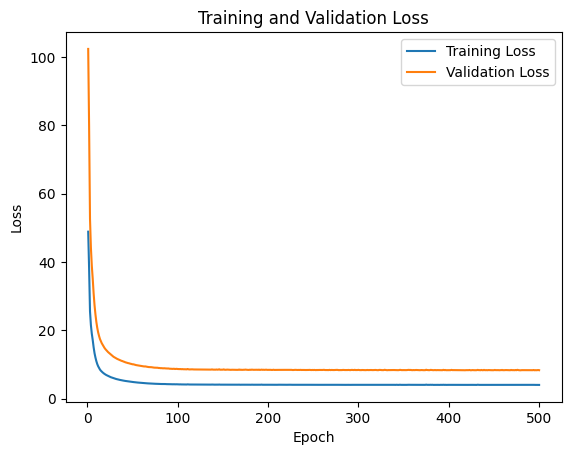

In [ ]:
# train the regressor
model = MLPRegressor(lr=0.001,epochs=500,activation_funcs=['relu','relu', 'linear'], layers=[2, 64,32,  3],l1_reg=0.0,l2_reg=0.0)
model.fit(X_train,y_train,X_val,y_val,batch_size=128,early_stopping=False)

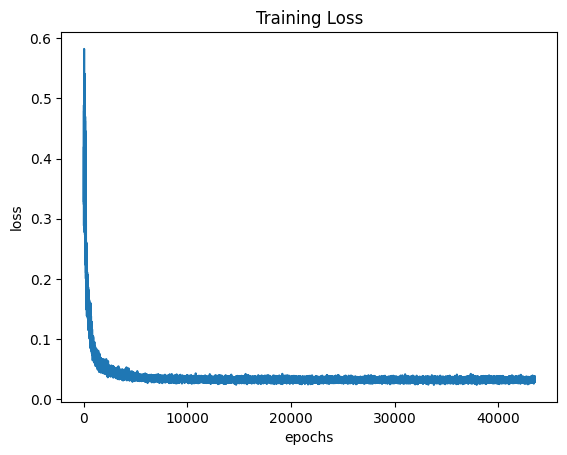

In [ ]:
# plot the training loss
plt.plot(model.loss)
plt.title("Training Loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [ ]:
# generate predictions
y_pred = model.predict(X_test)
predicted_Y_train=model.predict(X_train)

In [ ]:
# @title Error analysis functions
#Error analysis
def mean_squared_error(y1,y2):
  print('MSE for each target=',np.mean((y1-y2)**2,axis=0))
  return np.mean((y1-y2)**2,axis=0)


def mean_absolute_error(y1,y2):
  print('MAE for each target=',np.mean(abs(y1-y2),axis=0))
  return np.mean(abs(y1-y2),axis=0)

def root_mean_squared_error(y1,y2):
  print('RMSE for each target=',np.sqrt(np.mean((y1-y2)**2,axis=0)))
  return np.sqrt(np.mean((y1-y2)**2,axis=0))

def pearson_correlation(Y,predicted_Y):
  pearson_coeffs = np.zeros(np.shape(Y)[1])
    # Compute standard deviations
  std_actual = np.std(Y, axis=0)
  std_predicted = np.std(predicted_Y, axis=0)


  for i in range(np.shape(Y)[1]):
    covariance = np.sum((Y[:,i] - np.mean(Y[:,i])) * (predicted_Y[:,i] - np.mean(predicted_Y[:,i])))/(len(Y)-1)

      # Compute Pearson correlation coefficient
    pearson_coeffs[i] = covariance / (std_actual[i]* std_predicted[i])
  print('Pearson coefficients for each target:',pearson_coeffs)
  return pearson_coeffs



In [ ]:
# @title Evaluate model performance
# evaluate model performance
rmse=root_mean_squared_error(y_pred,y_test)
mse=mean_squared_error(y_pred,y_test)
mae=mean_absolute_error(y_pred,y_test)
r=pearson_correlation(y_pred,y_test)

RMSE for each target= [2.87095095 2.93647685 2.87024816]
MSE for each target= [8.24235936 8.62289632 8.23832452]
MAE for each target= [2.28679811 2.35175992 2.3107807 ]
Pearson coefficients for each target: [0.94764195 0.93397719 0.96505912]


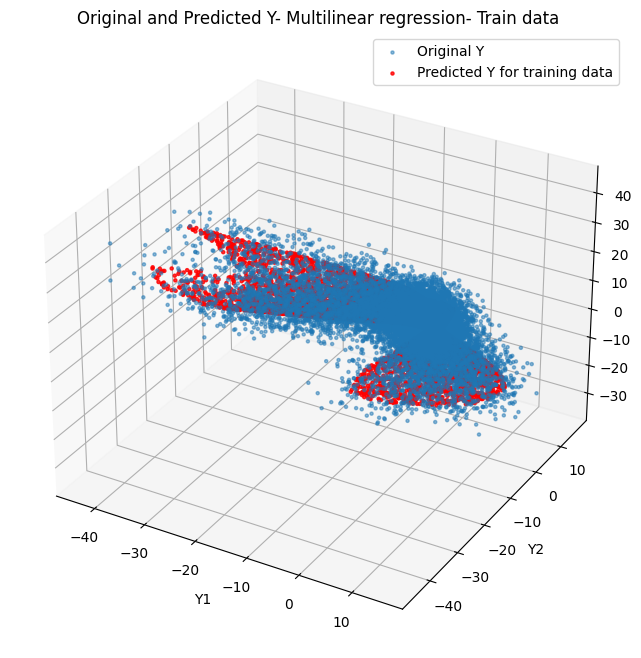

<Figure size 1000x800 with 0 Axes>

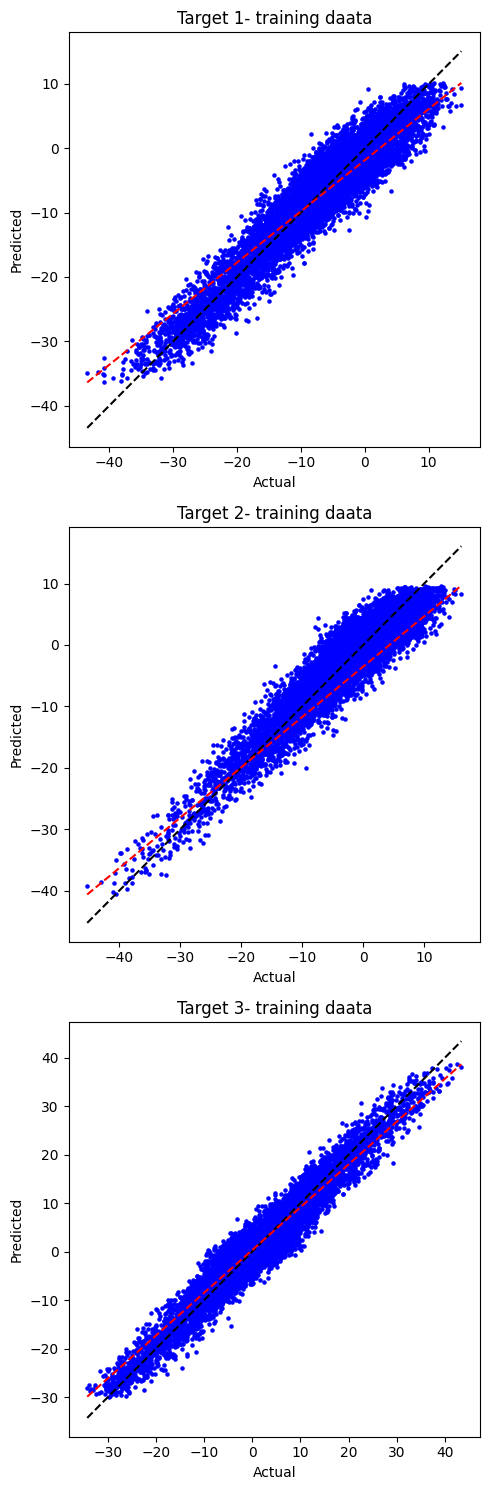

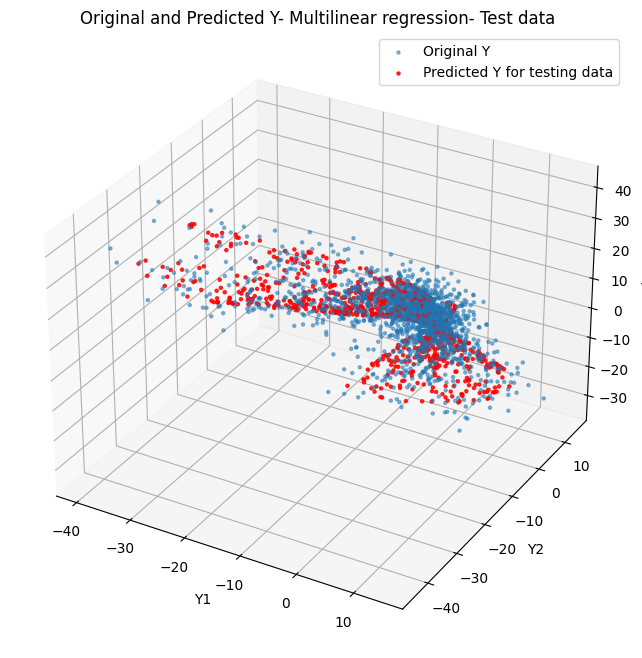

<Figure size 1000x800 with 0 Axes>

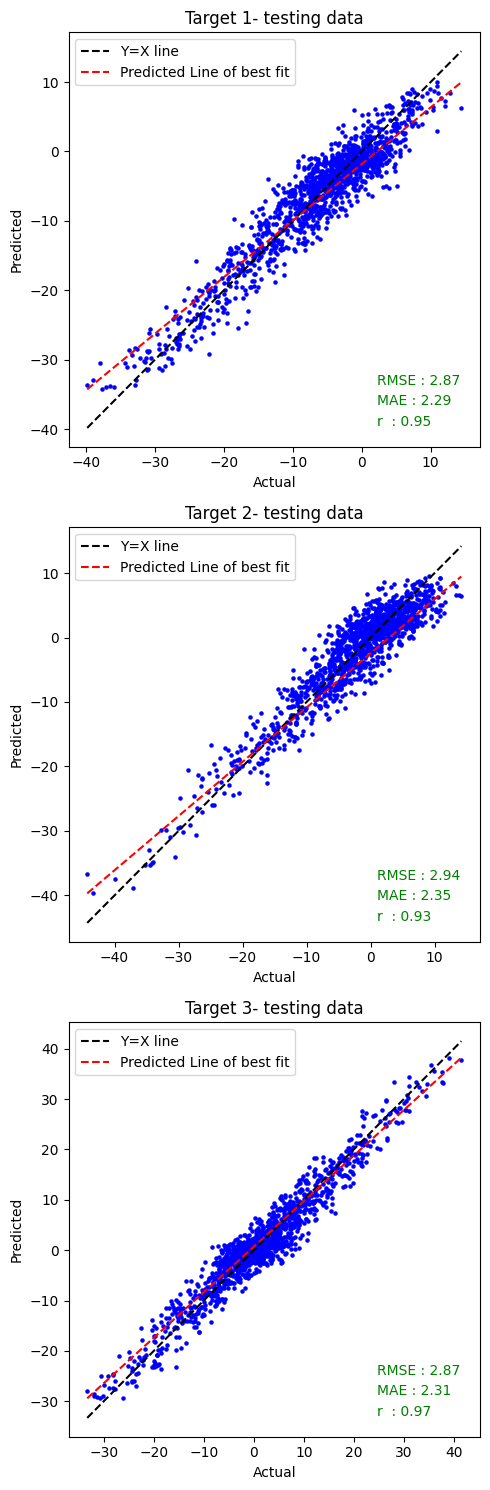

In [ ]:
# @title Visualization- Least squares loss function
# Plot the original and predicted points in 3D- train data
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(y_train[:, 0], y_train[:, 1], y_train[:, 2], label='Original Y', s=5,alpha=0.5)
ax.scatter(predicted_Y_train[:, 0], predicted_Y_train[:, 1], predicted_Y_train[:, 2],color='r', label='Predicted Y for training data', s=5,alpha=0.8)
#ax.text2D(0.85, 0.85, "RMSE: {:.2f}".format(rmse_total), transform=ax.transAxes, color='green', fontsize=10)

ax.set_xlabel('Y1')
ax.set_ylabel('Y2')
ax.set_zlabel('Y3')
ax.set_title('Original and Predicted Y- Multilinear regression- Train data')
ax.legend()
plt.show()

# Plot actual vs predicted targets
fig = plt.figure(figsize=(10, 8))



# Create subplots for each target variable
fig, axs = plt.subplots(3, 1, figsize=(5, 15))  # Adjust the number of subplots and figsize as needed

for i in range(3):
    # Scatter plot for actual vs predicted values
    Y=y_train
    predicted_Y=predicted_Y_train
    axs[i].scatter(Y[:, i], predicted_Y[:, i], color='blue', s=5)

    # Add lines
    axs[i].plot([Y[:, i].min(), Y[:, i].max()], [Y[:, i].min(), Y[:, i].max()], color='black', linestyle='--',label='Y=X line')
    axs[i].plot([Y[:, i].min(), Y[:, i].max()], [predicted_Y[:, i].min(), predicted_Y[:, i].max()], color='red', linestyle='--',label='Predicted Line of best fit')

    # Set labels and title
    axs[i].set_xlabel('Actual')
    axs[i].set_ylabel('Predicted')
    axs[i].set_title('Target {}- training daata'.format(i+1))


# Adjust layout
plt.tight_layout()

# Show plot
plt.show()



predicted_Y_test=y_pred
# Plot the original and predicted points for test data in 3D-
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(y_test[:, 0], y_test[:, 1], y_test[:, 2], label='Original Y', s=5,alpha=0.5)
ax.scatter(predicted_Y_test[:, 0], predicted_Y_test[:, 1], predicted_Y_test[:, 2],color='r', label='Predicted Y for testing data', s=5,alpha=0.8)
#ax.text2D(0.85, 0.85, "RMSE: {:.2f}".format(rmse_total), transform=ax.transAxes, color='green', fontsize=10)

ax.set_xlabel('Y1')
ax.set_ylabel('Y2')
ax.set_zlabel('Y3')
ax.set_title('Original and Predicted Y- Multilinear regression- Test data')
ax.legend()
plt.show()

# Plot actual vs predicted targets
fig = plt.figure(figsize=(10, 8))



# Create subplots for each target variable
fig, axs = plt.subplots(3, 1, figsize=(5, 15))  # Adjust the number of subplots and figsize as needed

for i in range(3):
    # Scatter plot for actual vs predicted values
    Y=y_test
    predicted_Y=predicted_Y_test
    axs[i].scatter(Y[:, i], predicted_Y[:, i], color='blue', s=5)

    # Add lines
    axs[i].plot([Y[:, i].min(), Y[:, i].max()], [Y[:, i].min(), Y[:, i].max()], color='black', linestyle='--',label='Y=X line')
    axs[i].plot([Y[:, i].min(), Y[:, i].max()], [predicted_Y[:, i].min(), predicted_Y[:, i].max()], color='red', linestyle='--',label='Predicted Line of best fit')

    # Set labels and title
    axs[i].set_xlabel('Actual')
    axs[i].set_ylabel('Predicted')
    axs[i].set_title('Target {}- testing data'.format(i+1))

    # Add errors as text
    axs[i].text(0.75, 0.15, "RMSE : {:.2f}".format(rmse[i]), transform=axs[i].transAxes, color='green', fontsize=10)
    axs[i].text(0.75, 0.10, "MAE : {:.2f}".format(mae[i]), transform=axs[i].transAxes, color='green', fontsize=10)
    axs[i].text(0.75, 0.05, "r  : {:.2f}".format(r[i]), transform=axs[i].transAxes, color='green', fontsize=10)
    axs[i].legend()


# Adjust layout
plt.tight_layout()

# Show plot
plt.show()







